# Training an ML Model (HoVer-Net)

[![View on GitHub](https://img.shields.io/badge/View-on%20GitHub-lightgrey?logo=github)](https://github.com/Dana-Farber-AIOS/pathml/blob/master/examples/train_hovernet.ipynb)

In this notebook, we will train HoVer-Net model to perform nucleus detection and classification, using data from PanNuke dataset. 

This notebook should be a good reference for how to do a full machine learning workflow using `PathML` and `PyTorch`

In [11]:
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
torch.cuda.empty_cache()
from torch.optim.lr_scheduler import StepLR
import albumentations as A

In [12]:
from pathml.datasets.pannuke import PanNukeDataModule
from pathml.ml.hovernet import HoVerNet, loss_hovernet, post_process_batch_hovernet
from pathml.ml.utils import wrap_transform_multichannel, dice_score
from pathml.utils import plot_segmentation

## Data augmentation

Data augmentation is the process of applying random transformations to the data before feeding it to the network. This introduces some noise and can help improve model performance by reducing overfitting. For example, each image can be randomly rotated by 90 degrees - the idea is that this would force the network to learn representations which are robust to rotation. 

Importantly, whatever transform is applied to the image also needs to be applied to the corresponding mask! 

We'll use the [Albumentations](http://albumentations.ai/) library to handle data augmentation.
You can also write custom data augmentations, but albumentations and other similar libraries (e.g. torchvision.transforms) are convenient because they automatically handle masks in the augmentation pipeline. 

However, because our masks have multiple channels, they are not natively supported by Albumentations. So we'll wrap each transform in the `wrap_transform_multichannel()` utility function which will make it compatible.

In [13]:
n_classes_pannuke = 6

# data augmentation transform 
hover_transform = A.Compose(
    [A.VerticalFlip(p=0.5), 
     A.HorizontalFlip(p=0.5),
     A.RandomRotate90(p=0.5),
     A.GaussianBlur(p=0.5),
     A.MedianBlur(p=0.5, blur_limit=5)], 
    additional_targets = {f"mask{i}" : "mask" for i in range(n_classes_pannuke)}
)

transform = wrap_transform_multichannel(hover_transform)

## Load PanNuke dataset

In [14]:
pannuke = PanNukeDataModule(
    data_dir= "/media/ckv1110/CHUN SATA/data/pannuke/",
    download=False,
    nucleus_type_labels=True,
    batch_size=2,
    hovernet_preprocess=True,
    split=1,
    transforms=transform
)

train_dataloader = pannuke.train_dataloader
valid_dataloader = pannuke.valid_dataloader
test_dataloader = pannuke.test_dataloader

Let's visualize what the inputs to HoVer-Net model look like:

IndexError: index 2 is out of bounds for dimension 0 with size 2

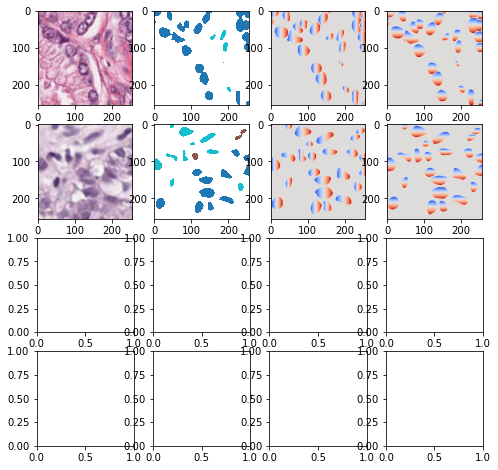

In [15]:
images, masks, hvs, types = next(iter(train_dataloader))

n = 4
fig, ax = plt.subplots(nrows=n, ncols=4, figsize = (8, 8))

cm_mask = copy.copy(cm.get_cmap("tab10"))
cm_mask.set_bad(color='white')

for i in range(n):
    im = images[i, ...].numpy()
    ax[i, 0].imshow(np.moveaxis(im, 0, 2))
    m = masks.argmax(dim=1)[i, ...]
    m = np.ma.masked_where(m == 5, m)
    ax[i, 1].imshow(m, cmap = cm_mask)
    ax[i, 2].imshow(hvs[i, 0, ...], cmap = 'coolwarm')
    ax[i, 3].imshow(hvs[i, 1, ...], cmap = 'coolwarm')
    
for a in ax.ravel(): a.axis("off")
for c,v in enumerate(["H&E Image", "Nucleus Types", "Horizontal Map", "Vertical Map"]):
    ax[0, c].set_title(v)
    
plt.tight_layout()
plt.show()

## Model Training

Now we are ready to train the HoVer-Net model.  
To train a model in PyTorch, we need to write a training loop ourselves to specify exactly how we want to train the model. This gives us precise control over exactly what we are doing, at the expense of somewhat verbose code.
[This tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) is a good reference.

#### Training with multi-GPU

When using GPUs with PyTorch, there are a few things to keep in mind when writing the training loop. For example, we need to explicitly move data to the GPU by calling `.to(device)`.  
For multi-GPU, we also need to wrap our model object with `torch.nn.DataParallel()`. 
PyTorch will then take care of all the tricky parts of distributing the computation across the GPUs.  

In [16]:
print(f"GPUs used:\t{torch.cuda.device_count()}")
device = torch.device("cuda:0")
print(f"Device:\t\t{device}")

GPUs used:	1
Device:		cuda:0


In [17]:
n_classes_pannuke = 6

# load the model
hovernet = HoVerNet(n_classes=n_classes_pannuke)

# wrap model to use multi-GPU
hovernet = torch.nn.DataParallel(hovernet)

In [18]:
# set up optimizer
opt = torch.optim.Adam(hovernet.parameters(), lr = 1e-4)
# learning rate scheduler to reduce LR by factor of 10 each 25 epochs
scheduler = StepLR(opt, step_size=25, gamma=0.1)

In [19]:
# send model to GPU
hovernet.to(device);

#### Main training loop

This contains all our logic for looping over batches, doing a forward pass through the network, computing the loss, and then stepping the model parameters to minimize the loss. We also add some code to evaluate the model on the validation set as we train, and to track the performance metrics throughout the training process.

In [20]:
n_epochs = 50

# print performance metrics every n epochs
print_every_n_epochs = None

# evaluating performance on a random subset of validation mini-batches
# this saves time instead of evaluating on the entire validation set
n_minibatch_valid = 25

epoch_train_losses = {}
epoch_valid_losses = {}
epoch_train_dice = {}
epoch_valid_dice = {}

best_epoch = 0

# main training loop
for i in tqdm(range(n_epochs)):
    minibatch_train_losses = []
    minibatch_train_dice = []
    
    # put model in training mode
    hovernet.train()
    
    for data in train_dataloader:
        # send the data to the GPU
        images = data[0].float().to(device)
        masks = data[1].to(device)
        hv = data[2].float().to(device)
        tissue_type = data[3]
        
        # zero out gradient
        opt.zero_grad()
        
        # forward pass
        outputs = hovernet(images)
        
        # compute loss
        loss = loss_hovernet(outputs = outputs, ground_truth = [masks, hv], n_classes=n_classes_pannuke)
        
        # track loss
        minibatch_train_losses.append(loss.item())
        
        # also track dice score to measure performance
        preds_detection, preds_classification = post_process_batch_hovernet(outputs, n_classes=n_classes_pannuke)
        truth_binary = masks[:, -1, :, :] == 0
        dice = dice_score(preds_detection, truth_binary.cpu().numpy())
        minibatch_train_dice.append(dice)
        
        # compute gradients
        loss.backward()
        
        # step optimizer and scheduler
        opt.step()
    
    #step LR scheduler
    scheduler.step()
    
    # evaluate on random subset of validation data
    hovernet.eval()
    minibatch_valid_losses = []
    minibatch_valid_dice = []
    # randomly choose minibatches for evaluating
    minibatch_ix = np.random.choice(range(len(valid_dataloader)), replace=False, size=n_minibatch_valid)
    with torch.no_grad():
        for j, data in enumerate(valid_dataloader):
            if j in minibatch_ix:
                # send the data to the GPU
                images = data[0].float().to(device)
                masks = data[1].to(device)
                hv = data[2].float().to(device)
                tissue_type = data[3]

                # forward pass
                outputs = hovernet(images)

                # compute loss
                loss = loss_hovernet(outputs = outputs, ground_truth = [masks, hv], n_classes=n_classes_pannuke)

                # track loss
                minibatch_valid_losses.append(loss.item())

                # also track dice score to measure performance
                preds_detection, preds_classification = post_process_batch_hovernet(outputs, n_classes=n_classes_pannuke)
                truth_binary = masks[:, -1, :, :] == 0
                dice = dice_score(preds_detection, truth_binary.cpu().numpy())
                minibatch_valid_dice.append(dice)
    
    # average performance metrics over minibatches
    mean_train_loss = np.mean(minibatch_train_losses)
    mean_valid_loss = np.mean(minibatch_valid_losses)
    mean_train_dice = np.mean(minibatch_train_dice)
    mean_valid_dice = np.mean(minibatch_valid_dice)
    
    # save the model with best performance
    if i != 0:
        if mean_valid_loss < min(epoch_valid_losses.values()):
            best_epoch = i
            torch.save(hovernet.state_dict(), f"hovernet_best_perf.pt")
    
    # track performance over training epochs
    epoch_train_losses.update({i : mean_train_loss})
    epoch_valid_losses.update({i : mean_valid_loss})
    epoch_train_dice.update({i : mean_train_dice})
    epoch_valid_dice.update({i : mean_valid_dice})
    
    if print_every_n_epochs is not None:
        if i % print_every_n_epochs == print_every_n_epochs - 1:
            print(f"Epoch {i+1}/{n_epochs}:")
            print(f"\ttraining loss: {np.round(mean_train_loss, 4)}\tvalidation loss: {np.round(mean_valid_loss, 4)}")
            print(f"\ttraining dice: {np.round(mean_train_dice, 4)}\tvalidation dice: {np.round(mean_valid_dice, 4)}")

# save fully trained model
torch.save(hovernet.state_dict(), f"hovernet_fully_trained.pt")
print(f"\nEpoch with best validation performance: {best_epoch}")

  0%|          | 0/50 [00:00<?, ?it/s]/home/ckv1110/miniconda3/envs/pathml/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 0/50 [00:02<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 7.79 GiB total capacity; 6.09 GiB already allocated; 65.19 MiB free; 6.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

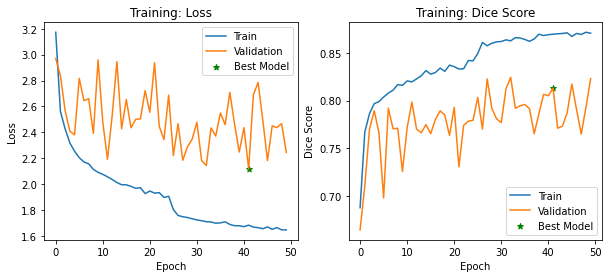

In [23]:
fix, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))

ax[0].plot(epoch_train_losses.keys(), epoch_train_losses.values(), label = "Train")
ax[0].plot(epoch_valid_losses.keys(), epoch_valid_losses.values(), label = "Validation")
ax[0].scatter(x=best_epoch, y=epoch_valid_losses[best_epoch], label = "Best Model",
              color = "green", marker="*")
ax[0].set_title("Training: Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(epoch_train_dice.keys(), epoch_train_dice.values(), label = "Train")
ax[1].plot(epoch_valid_dice.keys(), epoch_valid_dice.values(), label = "Validation")
ax[1].scatter(x=best_epoch, y=epoch_valid_dice[best_epoch], label = "Best Model",
              color = "green", marker="*")
ax[1].set_title("Training: Dice Score")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Dice Score")
ax[1].legend()
plt.show()

## Evaluate Model

Now that we have trained the model, we can evaluate performance on the held-out test set.

First we load the weights for the best model:

In [30]:
# load the best model
checkpoint = torch.load("hovernet_best_perf.pt")
hovernet.load_state_dict(checkpoint)

<All keys matched successfully>

Next, we loop through the test set and store the model predictions:

In [69]:
hovernet.eval()

ims = None
mask_truth = None
mask_pred = None
tissue_types = []

with torch.no_grad():
    for i, data in tqdm(enumerate(test_dataloader)):
        # send the data to the GPU
        images = data[0].float().to(device)
        masks = data[1].to(device)
        hv = data[2].float().to(device)
        tissue_type = data[3]

        # pass thru network to get predictions
        outputs = hovernet(images)
        preds_detection, preds_classification = post_process_batch_hovernet(outputs, n_classes=n_classes_pannuke)
        
        if i == 0:
            ims = data[0].numpy()
            mask_truth = data[1].numpy()
            mask_pred = preds_classification
            tissue_types.extend(tissue_type)
        else:
            ims = np.concatenate([ims, data[0].numpy()], axis=0)
            mask_truth = np.concatenate([mask_truth, data[1].numpy()], axis=0)
            mask_pred = np.concatenate([mask_pred, preds_classification], axis=0)
            tissue_types.extend(tissue_type)        

341it [16:56,  2.98s/it]


Now we can compute the Dice score for each image in the test set:

In [70]:
# collapse multi-class preds into binary preds
preds_detection = np.sum(mask_pred, axis=1)

dice_scores = np.empty(shape = len(tissue_types))

for i in range(len(tissue_types)):
    truth_binary = mask_truth[i, -1, :, :] == 0
    preds_binary = preds_detection[i, ...] != 0
    dice = dice_score(preds_binary, truth_binary)
    dice_scores[i] = dice

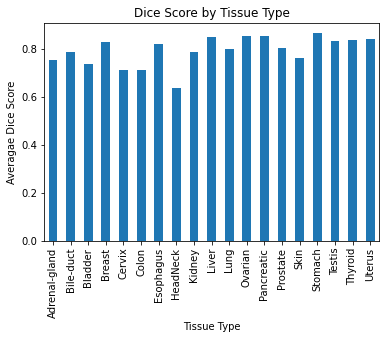

In [124]:
dice_by_tissue = pd.DataFrame({"Tissue Type" : tissue_types, "dice" : dice_scores})
dice_by_tissue.groupby("Tissue Type").mean().plot.bar()
plt.title("Dice Score by Tissue Type")
plt.ylabel("Averagae Dice Score")
plt.gca().get_legend().remove()
plt.show()

In [72]:
print(f"Average Dice score in test set: {np.mean(dice_scores)}")

Average Dice score in test set: 0.7850396088887557


## Examples

Let's take a look at some example predictions from the network to see how it is performing.

In [100]:
# change image tensor from (B, C, H, W) to (B, H, W, C)
# matplotlib likes channels in last dimension 
ims = np.moveaxis(ims, 1, 3)

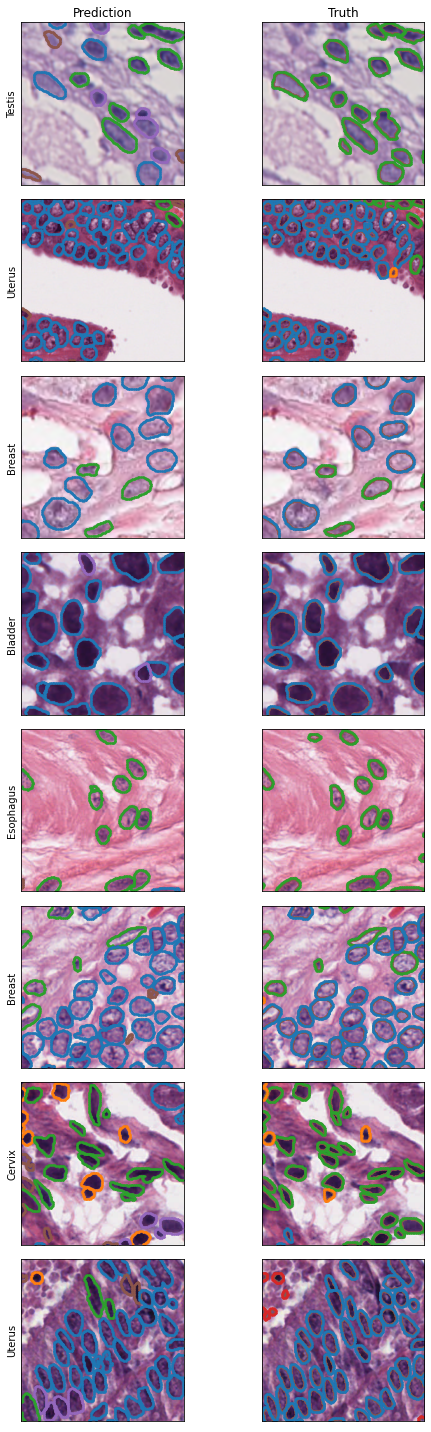

In [119]:
n = 8
ix = np.random.choice(np.arange(len(tissue_types)), size = n)
fig, ax = plt.subplots(nrows = n, ncols = 2, figsize = (8, 2.5*n))

for i, index in enumerate(ix):
    ax[i, 0].imshow(ims[index, ...])
    ax[i, 1].imshow(ims[index, ...])
    plot_segmentation(ax = ax[i, 0], masks = mask_pred[index, ...])
    plot_segmentation(ax = ax[i, 1], masks = mask_truth[index, ...])
    ax[i, 0].set_ylabel(tissue_types[index])
        
for a in ax.ravel(): 
    a.get_xaxis().set_ticks([])
    a.get_yaxis().set_ticks([])
    
ax[0, 0].set_title("Prediction")
ax[0, 1].set_title("Truth")
plt.tight_layout()
plt.show()

We can see that the model is doing quite well at nucleus detection, although there are some discrepancies in nucleus classification.

## Conclusion

We trained HoVer-Net from scratch on the public PanNuke dataset to perform simulataneous nucleus segmentation and classification. We wrote model training and evaluation loops in PyTorch, including code to distribute training across 4 GPUs. The trained model performs well, with an average Dice coefficient of 0.785 on held-out test set. We also evaluated performance across tissue types, finding that the model performs best in Stomach tissue and worst in Head & Neck tissue. 

Load this pre-trained model and test it out yourself!

## References

* Gamper, J., Koohbanani, N.A., Benet, K., Khuram, A. and Rajpoot, N., 2019, April. Pannuke: an open pan-cancer histology dataset for nuclei instance segmentation and classification. In European Congress on Digital Pathology (pp. 11-19). Springer, Cham.
* Graham, S., Vu, Q.D., Raza, S.E.A., Azam, A., Tsang, Y.W., Kwak, J.T. and Rajpoot, N., 2019. Hover-net: Simultaneous segmentation and classification of nuclei in multi-tissue histology images. Medical Image Analysis, 58, p.101563.

## Session info

In [26]:
import IPython
print(IPython.sys_info())
print(f"torch version: {torch.__version__}")

{'commit_hash': '223e783c4',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/opt/conda/envs/pathml/lib/python3.8/site-packages/IPython',
 'ipython_version': '7.19.0',
 'os_name': 'posix',
 'platform': 'Linux-4.19.0-12-cloud-amd64-x86_64-with-glibc2.10',
 'sys_executable': '/opt/conda/envs/pathml/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.8.6 | packaged by conda-forge | (default, Dec 26 2020, '
                '05:05:16) \n'
                '[GCC 9.3.0]'}
torch version: 1.7.1


In [29]:
# hash for PathML commit:
!git rev-parse HEAD

3f68d77d0c7b324acce74214e713a0bf79e60d84
